# Capstone Project - Battle Of The London Boroughs
### Applied Data Science Capstone by IBM/Coursera

### Importing third party libraries

## Introduction
This report is the final submission to the IBM Data Science Professional Certification Coursera course. Its aim is to demonstrate how today's data scientists can utilise the free APIs and open-source machine learning libraries to provide meaningful buisnes insights.

## The Business Problem
An estate agency has approached me. They wish to provide their customers with a service that analyses their current home address and identifies other locations that share similar features. Using the machine learning techniques taught throughout this course and a number of free APIs, this project will analyse a collection of South London Boroughs to classify and cluster those that share similar traits. This analysis would allow the agency to match its customers with the appropriate locations for a potential move.

## The Data
This project will utilise a number of data sources:
<ul>
    <li> The arcgis API for python </li>
    <li> The Foursquare API </li>
    <li> Postcodes.io API </li>
</ul>


In [82]:
# Third party library imports
import folium
import geocoder
import pandas as pd
import requests
import matplotlib.pyplot as plt
from dotenv import dotenv_values
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

%matplotlib inline

## Geocoder Library and ArcGIS
The ArcGIS and Geocoder libraries can be used together to retrieve geographical data for specific addresses. Using this API, I can retrieve the latitude and longitude for selected London postcodes, enabling me to plot them on a map.
<br>
Link: https://developers.arcgis.com

In [83]:
# National Physics Laboratory - Teddington, London
npl_geoData = geocoder.arcgis('TW11 0LW')
npl_geoData.geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'address': 'TW11 0LW',
    'bbox': [-0.34182997606174104,
     51.42260001403074,
     -0.33982997606174103,
     51.42460001403074],
    'confidence': 9,
    'lat': 51.42360001403074,
    'lng': -0.34082997606174104,
    'ok': True,
    'quality': 'PostalExt',
    'raw': {'name': 'TW11 0LW',
     'extent': {'xmin': -0.34182997606174104,
      'ymin': 51.42260001403074,
      'xmax': -0.33982997606174103,
      'ymax': 51.42460001403074},
     'feature': {'geometry': {'x': -0.34082997606174104,
       'y': 51.42360001403074},
      'attributes': {'Score': 100, 'Addr_Type': 'PostalExt'}}},
    'score': 100,
    'status': 'OK'},
   'bbox': [-0.34182997606174104,
    51.42260001403074,
    -0.33982997606174103,
    51.42460001403074],
   'geometry': {'type': 'Point',
    'coordinates': [-0.34082997606174104, 51.42360001403074]}}]}

## Forsquare API
The Forsquare API can be utilised to return venues and locations of interest within a given radious of a specific point. 
<br>
Link: https://foursquare.com

In [84]:
# Import foursquare credentials
config = dotenv_values('.env')

four_id = config['CLIENT_ID']
four_sc = config['CLIENT_SECRET']

In [86]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    four_id, 
    four_sc, 
    20120609, # Version number
    npl_geoData.lat, 
    npl_geoData.lng,
    100, # Search radious 100m
    100) # Top 100 results

results = requests.get(url).json()

In [87]:
# Here we see that there aren't many (1) locations of interest within 100m of the National Physics Laboratory (NPL)
results['response']

{'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
 'headerLocation': 'Teddington',
 'headerFullLocation': 'Teddington, London',
 'headerLocationGranularity': 'neighborhood',
 'totalResults': 0,
 'suggestedBounds': {'ne': {'lat': 51.42450001493074,
   'lng': -0.3393893385939807},
  'sw': {'lat': 51.422700013130736, 'lng': -0.3422706135295014}},
 'groups': [{'type': 'Recommended Places',
   'name': 'recommended',
   'items': []}]}

## Postcodes.io API
The postcode API allows users to send request based on the latitude and longitude or postcode of a location and retrieve information for that area. <br>
Link: https://postcodes.io

In [88]:
url_codes = 'https://api.postcodes.io/postcodes?lon={}&lat={}'.format(
    npl_geoData.lng, 
    npl_geoData.lat
)

codes = requests.get(url_codes).json()
codes['result'][0]

{'postcode': 'TW11 0LW',
 'quality': 1,
 'eastings': 515458,
 'northings': 170734,
 'country': 'England',
 'nhs_ha': 'London',
 'longitude': -0.340797,
 'latitude': 51.423865,
 'european_electoral_region': 'London',
 'primary_care_trust': 'Richmond and Twickenham',
 'region': 'London',
 'lsoa': 'Richmond upon Thames 021C',
 'msoa': 'Richmond upon Thames 021',
 'incode': '0LW',
 'outcode': 'TW11',
 'parliamentary_constituency': 'Twickenham',
 'admin_district': 'Richmond upon Thames',
 'parish': 'Richmond upon Thames, unparished area',
 'admin_county': None,
 'admin_ward': 'Teddington',
 'ced': None,
 'ccg': 'NHS South West London',
 'nuts': 'Hounslow and Richmond upon Thames',
 'codes': {'admin_district': 'E09000027',
  'admin_county': 'E99999999',
  'admin_ward': 'E05000530',
  'parish': 'E43000217',
  'parliamentary_constituency': 'E14001005',
  'ccg': 'E38000245',
  'ccg_id': '36L',
  'ced': 'E99999999',
  'nuts': 'TLI75',
  'lsoa': 'E01003888',
  'msoa': 'E02000804',
  'lau2': 'E090

# Methodology

To demonstrate the principle of this analysis, I will be trying to find locations similar to Teddington, London. It is safe to assume that any client will have an idea of where they would like to live, so rather than searching all of London, a very computationally heavy process, I will select a few popular boroughs and run comparisons over these. This would then allow us to provide the clients with a shortlist of potential areas. 

### Our client currently lives in Teddington
<ul>
  <li> <strong> Teddington </strong> - TW11 0AZ </li>
</ul>

### Our client wishes to stay in the south of London and has highlighted a number of places they would be interested in:
<ul>
  <li>Bromley - BR1 3NN </li>
  <li>Thornton Heath - CR7 7JG</li>
  <li>Croydon - CR0 2TA </li>
  <li>Surbiton - KT6 4PE</li>
  <li>Stoneleigh - KT19 0QZ</li>
  <li>Morden - SM4 5AZ</li>
  <li>Sutton - SM1 1DE</li>
  <li>Wallington - SM6 0DZ</li>
  <li>Tooting - SW17 0SU </li>
  <li>Norbury - SW16 4EJ </li>
  <li>Feltham - TW13 4BY </li>
  <li>Kingston - KT1 1SW </li>
</ul>

In [89]:
# We begin by initialising a dataframe of the desired boroughs
borough_df = pd.DataFrame([
  {'Town': 'Teddington'     , 'Latitude':'51.4268', 'Longitude':'-0.3313'},
  {'Town': 'Kingston'       , 'Latitude':'51.4123', 'Longitude':'-0.3007'},
  {'Town': 'Surbiton'       , 'Latitude':'51.3940', 'Longitude':'-0.3027'},
  {'Town': 'Stoneleigh'     , 'Latitude':'51.3631', 'Longitude':'-0.2478'},
  {'Town': 'Morden'         , 'Latitude':'51.3949', 'Longitude':'-0.1945'},
  {'Town': 'Sutton'         , 'Latitude':'51.3614', 'Longitude':'-0.1940'},
  {'Town': 'Wallington'     , 'Latitude':'51.3640', 'Longitude':'-0.1518'},
  {'Town': 'Thornton Heath' , 'Latitude':'51.3967', 'Longitude':'-0.1055'},
  {'Town': 'Bromley'        , 'Latitude':'51.4060', 'Longitude':'-0.0132'}, 
  {'Town': 'Croydon'        , 'Latitude':'51.3762', 'Longitude':'-0.0982'}, 
  {'Town': 'Tooting'        , 'Latitude':'51.4282', 'Longitude':'-0.1669'},
  {'Town': 'Norbury'        , 'Latitude':'51.4086', 'Longitude':'-0.1214'},
  {'Town': 'Putney'         , 'Latitude':'51.4596', 'Longitude':'-0.2141'},
  {'Town': 'Feltham'        , 'Latitude':'51.4441', 'Longitude':'-0.4108'},
])

## Visulise these locations on a map

Data analysis should always be closely linked with visualisation of the data.

Geographical data should be plotted onto a map regularly, slowly building a picture of the analysis process over time. 

In [90]:
# Plotting data to a Folium map
sw_London = folium.Map(location=[51.4, -0.20], zoom_start=11)

for i, row in borough_df.iterrows():
    if row.Town == 'Teddington':
        col = 'red'  # Highlight Teddington in red
    else:
        col = 'blue'
    label = folium.Popup(f'{row.Town}')

    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        radius=8,
        popup=label,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.3,
        parse_html=False).add_to(sw_London) 
sw_London

Now that we have a shortlist of boroughs our client is willing to move to, we can use the **postcodes.io** API to retrieve postcodes from surrounding areas.

Before we begin with our more comprehensive analysis, we can establish our process with a preliminary analysis of Teddington. Once this is established, we can apply the same methodology to our selected boroughs.

In [19]:
# Request postcodes within a 1km radius of central Teddington
teddington_codes = 'https://api.postcodes.io/postcodes?lon={}&lat={}&limit={}&radius={}'.format(
   -0.3313,
   51.4268,
   100,
   1000,
)
teddington_codes = requests.get(teddington_codes).json()
teddington_codes_df = pd.DataFrame(pd.json_normalize(teddington_codes['result']))
teddington_codes_df = teddington_codes_df[['postcode', 'longitude', 'latitude']]
teddington_codes_df['Town'] = 'Teddington'
teddington_codes_df.head()

,postcode,longitude,latitude,Town
0,TW11 9AN,-0.331181,51.426472,Teddington
1,TW11 9BA,-0.330703,51.426950,Teddington
2,TW11 9AL,-0.331571,51.426414,Teddington
3,TW11 8HB,-0.331711,51.427315,Teddington
4,TW11 8HA,-0.331147,51.427397,Teddington


We again want to visualise these locations on a map.

In [92]:
# Center Map on Teddington and increase the Zoom level
teddingtom_map = folium.Map(location=[
        borough_df['Latitude'].loc[borough_df['Town']== 'Teddington'], 
        borough_df['Longitude'].loc[borough_df['Town']== 'Teddington']
    ], 
    zoom_start=16
)

# Highlight Central Teddington
folium.CircleMarker(
    [
        borough_df['Latitude'].loc[borough_df['Town']== 'Teddington'], 
        borough_df['Longitude'].loc[borough_df['Town']== 'Teddington']
    ],
    radius=10,
    popup='Teddington',
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.3,
    parse_html=False).add_to(teddingtom_map) 

# Add response locations to map
for i, row in teddington_codes_df.iterrows():
    label = folium.Popup(f'{row.postcode}')
    folium.CircleMarker(
        [row.latitude, row.longitude],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.3,
        parse_html=False).add_to(teddingtom_map) 

# show map
teddingtom_map

Now that we have visualised the data, we can see that the density of unique postcodes means our search does not return a very wide area - far smaller than the specified 1km radius. This is due to the limitation of the free version of the postcodes API, as we are limited to a maximum of 100 results per request.

Because of this, we will slightly change the approach and instead attempt to bring back notable locations within 2km of the town centre. 

In [93]:
# Bring back all the noted locations in the surounding area 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    four_id, 
    four_sc, 
    20120609,
    # Centre search on North Your district 
    borough_df.loc[borough_df.Town == 'Teddington'].Latitude[0], 
    borough_df.loc[borough_df.Town == 'Teddington'].Longitude[0],
    # Search radious 1000m 
    2000, 
    # Top 300 results
    300)

results = requests.get(url).json()
print(f'Returning {results["response"]["totalResults"]} locations of interest for Teddington')


Returning 89 locations of interest for Teddington


In [99]:
# Build a pandas datafrom from these results

def get_category_type(row: str):
    ''' 
    |   This function reads in the dataFrame row and looks to return the name of a venue.
    '''

    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


# convert response json into dataframe
teddington_places_df = pd.DataFrame(pd.json_normalize(results['response']['groups'][0]['items']))
# extract the important data items
teddington_places_df = teddington_places_df[['venue.name', 'venue.location.postalCode', 'venue.categories', 'venue.location.lat', 'venue.location.lng']]
teddington_places_df['venue.categories'] = teddington_places_df.apply(get_category_type, axis=1)

# rename columns
teddington_places_df = teddington_places_df.rename(
    columns={
        'venue.name': 'Name', 
        'venue.location.postalCode':'Postcode', 
        'venue.categories': 'Category', 
        'venue.location.lat':'Latitude', 
        'venue.location.lng': 'Longitude'
    }
)

# We remove any results with missing data
teddington_places_df = teddington_places_df.dropna()
teddington_places_df.head()

,Name,Postcode,Category,Latitude,Longitude
0,The Fallow Deer Café,TW11 8HG,Café,51.427435,-0.327876
1,Nando's,TW11 8EW,Portuguese Restaurant,51.426546,-0.333797
2,The Masons Arms,TW11 8PJ,Pub,51.426739,-0.339160
3,Bushy Park,TW12 2EJ,Park,51.417232,-0.337275
4,The Wharf Restaurant And Bar,TW11 8BG,Restaurant,51.430381,-0.325701


In [101]:
# Some of the postcodes returend by the API are slightly wrong. Here we are cleaning the data and replacing the erronious postcode
teddington_places_df = teddington_places_df.replace('KT11 8HA', 'TW11 8HA')

In [104]:
# Again we will visualise these location on a map

teddingtom_map = folium.Map(location=[
        borough_df['Latitude'].loc[borough_df['Town']== 'Teddington'], 
        borough_df['Longitude'].loc[borough_df['Town']== 'Teddington']
    ], 
    zoom_start=14
)

# Add response locations to map
for i, row in teddington_places_df.iterrows():
    label = folium.Popup(f'{row.Name}')
    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        radius=8,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.4,
        parse_html=False).add_to(teddingtom_map) 

# generate map marking Teddington 
folium.CircleMarker(
    [
        borough_df['Latitude'].loc[borough_df['Town']== 'Teddington'], 
        borough_df['Longitude'].loc[borough_df['Town']== 'Teddington']
    ],
    radius=15,
    popup='Teddington',
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.3,
    parse_html=False).add_to(teddingtom_map) 

# show map
teddingtom_map

Now that we have retrieved and plotted the locations of note for Teddington let's see if we can cluster them.
By clustering these locations, we can identify similar areas within specific towns. 

In [108]:
# We will begin by inspecting the catagories of the locations. 
print(f'We begin with {len(teddington_places_df.Category.unique())} different catagories.')
teddington_places_df.Category.value_counts()

We begin with 37 different catagories.


Pub                         11
Café                         6
Bakery                       4
Grocery Store                4
Hotel                        4
Coffee Shop                  3
Restaurant                   3
Italian Restaurant           3
Park                         3
Pizza Place                  3
Mediterranean Restaurant     2
Indian Restaurant            2
Supermarket                  2
Train Station                2
Gastropub                    2
Chinese Restaurant           1
Bookstore                    1
Garden                       1
Thai Restaurant              1
Gym / Fitness Center         1
German Restaurant            1
Optical Shop                 1
Pharmacy                     1
Butcher                      1
Portuguese Restaurant        1
Bar                          1
Golf Course                  1
Performing Arts Venue        1
Newsagent                    1
Sports Bar                   1
French Restaurant            1
Fast Food Restaurant         1
Wine Sho

We can immediately see that we can generalise some of these categories, grouping things like different restaurant cuisines under a single "restaurant" heading. This will make it easier to cluster areas; however, we will lose some information in the process. Were we to perform a more in-depth analysis of the specific regions, we may wish to retain this information to locate districts such as the Italian areas with typical pizza restaurants and specialist grocery shops or to highlight industrial estates with various hardware suppliers. 

In [149]:
ted_locations_df = teddington_places_df.copy()

# Convert postcodes to all upper case
ted_locations_df['Postcode'] = ted_locations_df['Postcode'].str.upper()

# beginning with some very simple lambda functions we can reduce our initial 151 catagories down to 101
ted_locations_df.Category = ted_locations_df.Category.apply(lambda x: 'Restaurant' if 'Restaurant' in x else x)
ted_locations_df.Category = ted_locations_df.Category.apply(lambda x: 'Pub' if 'Pub' in x else x)
ted_locations_df.Category = ted_locations_df.Category.apply(lambda x: 'Café' if 'Café' in x else x)
ted_locations_df.Category = ted_locations_df.Category.apply(lambda x: 'Café' if 'Cafe' in x else x)
ted_locations_df.Category = ted_locations_df.Category.apply(lambda x: 'Café' if 'Coffee' in x else x)
ted_locations_df.Category = ted_locations_df.Category.apply(lambda x: 'Bar' if 'Bar' in x else x)
ted_locations_df.Category = ted_locations_df.Category.apply(lambda x: 'Public Transport' if 'Station' in x else x)
ted_locations_df.Category = ted_locations_df.Category.apply(lambda x: 'Public Transport' if 'Bus' in x else x)
ted_locations_df.Category = ted_locations_df.Category.apply(lambda x: 'Gym' if 'Gym' in x else x)

 # Inspecting the remaining catagory list we can see other locations we can class as "restrauents"
other_restrauants = ['Pizza Place','Gastropub']
for R in other_restrauants:
  ted_locations_df.Category = ted_locations_df.Category.apply(lambda x: 'Restaurant' if R in x else x)

# Other catagories we can class as "shops"
other_shops = [ 'Bookstore','Garden Center','Pharmacy','Optical Shop',
  'Grocery Store','Newsagent','Supermarket','Bakery','Convenience Store','Wine Shop']
for S in other_shops:
  ted_locations_df.Category = ted_locations_df.Category.apply(lambda x: 'Shops' if S in x else x)

# and others we can count as sports facilities
other_sports = [ 'Park','Gym','Pool','Athletics & Sports','Golf Course']
for Sp in other_sports:
  ted_locations_df.Category = ted_locations_df.Category.apply(lambda x: 'SportsFacilities' if Sp in x else x)

print(f"we have now reduced our initial {len(teddington_places_df.Category.value_counts())} feature set down to {len(ted_locations_df.Category.unique())}")

we have now reduced our initial 37 feature set down to 14


Next we need to convert our catagory 'sting' values into 'number' values. For this we will utilise the **one hot encoding** technique. 

In [150]:
# Get one hot encoding of Category column
one_hot_encoding_teddington = pd.get_dummies(ted_locations_df['Category'])

# create a new dataframe
# given we are looking at areas in Teddington, we only need the Postcode value from our londown town frame
one_hot_encoding_teddington = ted_locations_df.drop(
    ['Name', 'Latitude', 'Longitude', 'Category'], 
    axis=1,
  ).join(
    one_hot_encoding_teddington
  )

one_hot_encoding_teddington

,Postcode,Bar,Butcher,Café,Deli / Bodega,Garden,History Museum,Hotel,Performing Arts Venue,Pub,Public Transport,Restaurant,Shops,SportsFacilities,Theater
0,TW11 8HG,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,TW11 8EW,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,TW11 8PJ,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,TW12 2EJ,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,TW11 8BG,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,TW12 1NL,0,1,0,0,0,0,0,0,0,0,0,0,0,0
84,TW12 1NY,0,0,0,0,0,0,0,0,0,0,0,0,0,1
85,TW12 1NL,0,0,0,0,0,0,0,0,0,0,1,0,0,0
87,KT2 5PU,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [151]:
# we need to seperate the postcode into its constituent out-code and inward-code, this allows us to better group our encoded values and return a mean.
one_hot_encoding_teddington[['outCode','inCode']] = one_hot_encoding_teddington['Postcode'].str.split(' ',expand=True)

# And we are going to group by the out-code, given this is the wider area. 
one_hot_encoding_teddington = one_hot_encoding_teddington.drop(['Postcode', 'inCode'], axis=1)


In [152]:
# we now group these by postcode and generate counts of each category for each town. 
one_hot_encoding_teddington = one_hot_encoding_teddington.groupby(by=['outCode']).mean().reset_index()
one_hot_encoding_teddington

,outCode,Bar,Butcher,Café,Deli / Bodega,Garden,History Museum,Hotel,Performing Arts Venue,Pub,Public Transport,Restaurant,Shops,SportsFacilities,Theater
0,KT1,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
1,KT2,0.000000,0.0,0.166667,0.000000,0.0,0.000000,0.000000,0.000000,0.166667,0.000000,0.166667,0.500000,0.000000,0.0
2,T,0.000000,0.0,0.333333,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.0
3,TW1,0.000000,0.0,0.000000,0.000000,0.0,0.333333,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.0
4,TW10,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.333333,0.000000,0.0
5,TW11,0.044444,0.0,0.133333,0.022222,0.0,0.000000,0.066667,0.022222,0.155556,0.022222,0.333333,0.155556,0.044444,0.0
6,TW12,0.000000,0.1,0.100000,0.000000,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,0.200000,0.100000,0.1
7,TW2,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.400000,0.000000,0.200000,0.400000,0.000000,0.0


Now that we have cleaned and grouped our locations, we can begin our clustering analysis. 

In [153]:
def get_inertia(n_clusters: int, X):
    '''
    |   This function accepts a the number of clusters (n_clusters) as well as the encoded data set (X) and returns the inertia for said data.
    |   Inertia can be recognized as a measure of how internally coherent clusters are.
    '''
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=20, random_state=5)
    km.fit(X)
    return km.inertia_

In [154]:
# Drop the outcodes from the dataset
townFeatures = one_hot_encoding_teddington.drop(['outCode'], axis=1)
# Attempt to cluster the data using a range of number of clusters.
scores = [get_inertia(x, townFeatures) for x in range(2, 9)]

Text(0, 0.5, 'Inertia')

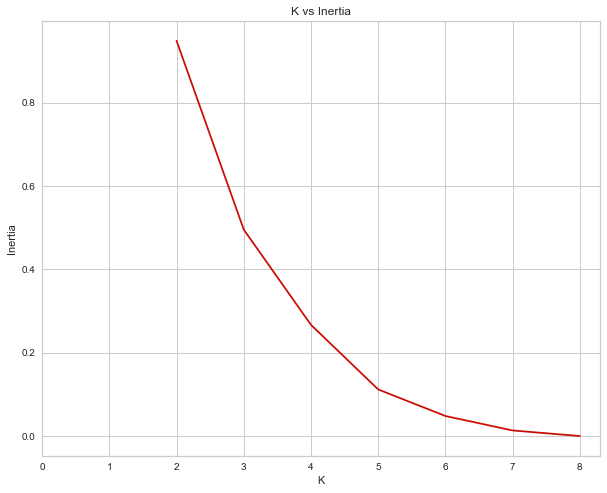

In [155]:
# Plot the inertia for each number of clusters
plt.figure(figsize=[10, 8])
plt.plot(range(2, 9), scores, color='r')
plt.title("K vs Inertia")
plt.xticks(range(0, 9))
plt.xlabel("K")
plt.ylabel("Inertia")

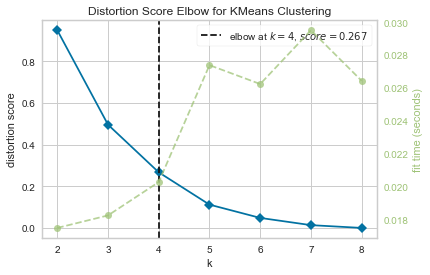

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [156]:
# Wuth KNN clustering, you are looking for the "elbow" in the inertia graph. 
# Although this is obviously at K=4 in the graph above, we can also use specific python packages to identify this point.
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,9))

# Fit the data to the visualizer
visualizer.fit(townFeatures)        
visualizer.show()

In [157]:
# run k-means clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(townFeatures)
one_hot_encoding_teddington['Cluster'] = kmeans.labels_
# We thin join these clustes back with our encoded data
teddingtonClusters = one_hot_encoding_teddington[['outCode', 'Cluster']]

We can use our postcodes.io API to find the central position of each of the outcodes

In [158]:
tClusters = teddingtonClusters.copy()
for i, row in teddingtonClusters.iterrows():
  out = 'https://api.postcodes.io/outcodes/{}'.format(
    row.outCode
  )
  out = requests.get(out).json()
  try:
    
    tClusters.loc[i, 'latitude'] = out['result']['latitude']
    tClusters.loc[i, 'longitude'] = out['result']['longitude']
  except:
    pass

# Set the outCode value of T to the teddingting center lat, long
tClusters.loc[2, 'latitude'] = 51.4268
tClusters.loc[2, 'longitude'] = -0.3313


In [159]:
ted_locations_df

,Name,Postcode,Category,Latitude,Longitude
0,The Fallow Deer Café,TW11 8HG,Café,51.427435,-0.327876
1,Nando's,TW11 8EW,Restaurant,51.426546,-0.333797
2,The Masons Arms,TW11 8PJ,Pub,51.426739,-0.339160
3,Bushy Park,TW12 2EJ,SportsFacilities,51.417232,-0.337275
4,The Wharf Restaurant And Bar,TW11 8BG,Restaurant,51.430381,-0.325701
...,...,...,...,...,...
83,Robson’s Butcher and Deli,TW12 1NL,Butcher,51.428007,-0.355040
84,Hampton Hill Playhouse,TW12 1NY,Theater,51.427383,-0.355144
85,The Beech House,TW12 1NL,Restaurant,51.427388,-0.355460
87,Rowley’s of Ham,KT2 5PU,Shops,51.430581,-0.307174


In [160]:
# And finally join the clusstering values back to the location data.
ted_locations_df[['outCode','inCode']] = ted_locations_df['Postcode'].str.split(' ',expand=True)
ted_locations_df = pd.merge(ted_locations_df, tClusters)
ted_locations_df.head()

,Name,Postcode,Category,Latitude,Longitude,outCode,inCode,Cluster,latitude,longitude
0,The Fallow Deer Café,TW11 8HG,Café,51.427435,-0.327876,TW11,8HG,0,51.426312,-0.331778
1,Nando's,TW11 8EW,Restaurant,51.426546,-0.333797,TW11,8EW,0,51.426312,-0.331778
2,The Masons Arms,TW11 8PJ,Pub,51.426739,-0.339160,TW11,8PJ,0,51.426312,-0.331778
3,The Wharf Restaurant And Bar,TW11 8BG,Restaurant,51.430381,-0.325701,TW11,8BG,0,51.426312,-0.331778
4,Shambles Bar & Restaurant,TW11 8HG,Restaurant,51.427257,-0.330023,TW11,8HG,0,51.426312,-0.331778


In [162]:
# visualise these loctations on a map
teddingtom_map = folium.Map(location=[
        borough_df['Latitude'].loc[borough_df['Town']== 'Teddington'], 
        borough_df['Longitude'].loc[borough_df['Town']== 'Teddington']
    ], 
    zoom_start=13
)
# generate map marking Teddington 
folium.CircleMarker(
    [
        borough_df['Latitude'].loc[borough_df['Town']== 'Teddington'], 
        borough_df['Longitude'].loc[borough_df['Town']== 'Teddington']
    ],
    radius=15,
    popup='Teddington',
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.3,
    parse_html=False).add_to(teddingtom_map) 

colours = ['#f51165', '#db910f', '#600e8f', '#01163b', '#55afbd', '#5abf1f', '#022663', '#4f3810', '#146648']

# Plot the locations of interest back on the map, coloured according to their specific cluster. 
for i, row in ted_locations_df.iterrows():
    label = folium.Popup(f'{row.Name}')
    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        radius=5,
        popup=label,
        color=colours[row.Cluster],
        ill=True,
        fill_color=colours[row.Cluster],
        fill_opacity=0.3,
        parse_html=False).add_to(teddingtom_map) 

# Add Outcode center points to map
for i, row in tClusters.iterrows():
    label = folium.Popup(f'{row.outCode}')
    folium.CircleMarker(
        [row.latitude, row.longitude],
        radius=10,
        popup=label,
        color=colours[int(row.Cluster)],
        fill=True,
        fill_color=colours[int(row.Cluster)],
        fill_opacity=0.5,
        parse_html=False).add_to(teddingtom_map) 

# show map
teddingtom_map

Now that we have broken Teddington down into various regions, we can apply the same steps of analysis to the other South London boroughs. 

In [163]:
# Lets start by adding teddington to a new London Towns data frame.
londonTowns_df = teddington_places_df[['Name', 'Postcode', 'Category', 'Latitude', 'Longitude']]
londonTowns_df['Town'] = 'Teddington'

# Next we will iterate through the other towns. 
# Note we are dropping the 0th position of the dataframe - Teddingon _ as we already have this information
for i, row in borough_df.drop([0]).iterrows():
  url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
      four_id, 
      four_sc, 
      20120609,
      # Centre search on North Your district 
      float(row.Latitude), 
      float(row.Longitude),
      # Search radious 2.5km 
      2500, 
      # Top 100 results
      300)

  results = requests.get(url).json()
  
  print('----- ----- -----')
  print(f'Results for {row.Town}')
  print('Request response code: ', results['meta']['code'])
  print('Returned ', results['response']['totalResults'], ' items')


  # convert response json into dataframe
  town_df = pd.DataFrame(pd.json_normalize(results['response']['groups'][0]['items']))
  # extract the important data items
  town_df = town_df[['venue.name', 'venue.location.postalCode', 'venue.categories', 'venue.location.lat', 'venue.location.lng']]
  town_df['venue.categories'] = town_df.apply(get_category_type, axis=1)

  town_df['Town'] = row.Town

  # rename columns
  town_df = town_df.rename(
      columns={
          'venue.name': 'Name', 
          'venue.location.postalCode':'Postcode', 
          'venue.categories': 'Category', 
          'venue.location.lat':'Latitude', 
          'venue.location.lng': 'Longitude'
      }
  )
  
  # Here we are dropping any results where we cant retrieve at least one of any of the fields
  town_df = town_df.dropna()
  # And then concatenating the results with the londonTowns dataframe
  londonTowns_df = pd.concat([londonTowns_df, town_df], ignore_index=True)

print('----- ----- -----')
print('----- API calls complete -----')
print(f'Returned {len(londonTowns_df)} locations of interest')

----- ----- -----
Results for Kingston
Request response code:  200
Returned  70  items
----- ----- -----
Results for Surbiton
Request response code:  200
Returned  213  items
----- ----- -----
Results for Stoneleigh
Request response code:  200
Returned  61  items
----- ----- -----
Results for Morden
Request response code:  200
Returned  102  items
----- ----- -----
Results for Sutton
Request response code:  200
Returned  65  items
----- ----- -----
Results for Wallington
Request response code:  200
Returned  54  items
----- ----- -----
Results for Thornton Heath
Request response code:  200
Returned  80  items
----- ----- -----
Results for Bromley
Request response code:  200
Returned  88  items
----- ----- -----
Results for Croydon
Request response code:  200
Returned  94  items
----- ----- -----
Results for Tooting
Request response code:  200
Returned  205  items
----- ----- -----
Results for Norbury
Request response code:  200
Returned  52  items
----- ----- -----
Results for Putney
R

Next we again apply the grouping exercise, however have to spend a little more time inspecting the various catagories, given there are far more than before. 

In [164]:
# We will reinitialise the londonTowns_df_grouped_2
londonTowns_df_grouped = londonTowns_df.copy()
londonTowns_df_grouped['Postcode'] = londonTowns_df_grouped['Postcode'].str.upper()

# First we consider they types of restaurants, rather than simply grouping them into "Restaurant".
italianRes  = ['Italian Restaurant', 'Italian Restaurant', 'Pizza Place', 'Gelato Shop']
indianRes   = ['Indian Restaurant', 'Indian Restaurant', 'South Indian Restaurant', 'Sri Lankan Restaurant']
asianRes    = ['Asian Restaurant', 'Thai Restaurant', 'Chinese Restaurant', 'Sushi Restaurant', 'Japanese Restaurant', 
               'Asian Restaurant', 'Vietnamese Restaurant', 'Korean Restaurant', 'Malay Restaurant', 'Noodle House',  
               'Pakistani Restaurant']
europeanRes = ['European Restaurant', 'German Restaurant', 'French Restaurant', 'Spanish Restaurant', 'Tapas Restaurant', 
               'Mediterranean Restaurant', 'Portuguese Restaurant', 'Modern European Restaurant', 
               'Scandinavian Restaurant', 'Eastern European Restaurant', 'Bistro']
southAmeRes = ['South American Restaurant', 'Burrito Place', 'Caribbean Restaurant', 'Brazilian Restaurant', 
               'Cajun / Creole Restaurant', 'Mexican Restaurant']
miscRes     = ['Restaurant', 'Sandwich Place', 'Breakfast Spot', 'Buffet' 'Food Court', 'Vegetarian / Vegan Restaurant']
midEastRes  = ['Middle Eastern Restaurant', 'Lebanese Restaurant', 'Middle Eastern Restaurant', 'Turkish Restaurant', 'Kebab Restaurant']
americanRes = ['American Restaurant', 'Diner', 'BBQ Joint', 'Steakhouse', 'American Restaurant', 'Fast Food Restaurant', 'Burger Joint']
englishRes  = ['English Restaurant', 'Fish & Chips Shop', 'Gastropub', 'English Restaurant', 'Seafood Restaurant', 'Pie Shop']
dessertRes  = ['Dessert Restaurant', 'Donut Shop', 'Creperie', 'Dessert Shop', 'Ice Cream Shop']

resLists = [italianRes, indianRes, asianRes, europeanRes, southAmeRes, miscRes, midEastRes, americanRes, englishRes, dessertRes]

for resType in resLists:
  for R in resType[1:]:
    londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: resType[0] if R in x else x)

In [165]:
sportsFacility  = ['Gym / Fitness Center', 'Golf Course', 'Tennis Court', 'Soccer Field', 'Pool', 'Athletics & Sports', 'Soccer Stadium'
                   'Rugby Pitch', 'Gym Pool', 'Yoga Studio', 'Sports Club', 'Skating Rink', 'Climbing Gym', 'Mini Golf', 'Gym']
foodStore       = ['Deli / Bodega', 'Grocery Store', 'Supermarket', 'Bakery', 'Wine Shop', 'Market', 'Chocolate Shop', 'Candy Store', 'Fish Market']
entertainment   = ['History Museum', 'Movie Theater', 'Indie Movie Theater', 'Performing Arts Venue', 'Theater', 'Pedestrian Plaza', 'Public Art'
                   'Go Kart Track', 'Playground', 'Bowling Alley', 'Indoor Play Area', 'Historic Site', 'Museum', 'Waterfront', 'Scenic Lookout',
                   'Nature Preserve', 'Park', 'Lake', 'Gaming Cafe', 'Brewery']
bar             = ['Rock Club', 'Jazz Club', 'Wine Bar', 'Juice Bar', 'Cocktail Bar', 'Bar', 'Sports Bar', 'Beer Bar', 'Smoothie Shop']
Pub             = ['Pub' , 'Irish Pub', 'Beer Garden']
cafe            = ['Café', 'Coffee Shop', 'Pet Café', 'Tea Room']
publicTransport = ['Train Station', 'Metro Station', 'Tram Station']
shops           = ['Bookstore', 'Newsagent', 'Convenience Store', 'Gift Shop', 'Record Shop', 'Clothing Store', 'Department Store', 'Electronics Store', 
                   'Warehouse Store', 'Video Game Store', 'Shopping Plaza', 'Sporting Goods Shop', 'Arts & Crafts Store', 'Kids Store', 'Beer Store', 
                   'Cosmetics Shop', 'Pharmacy', 'Optical Shop', 'Furniture / Home Store', 'Bike Shop', 'Flea Market', 'Pet Store' ]
diyShop          = ['Garden Center', 'Garden', 'Hardware Store' ]

for e in entertainment:
    londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Entertainment' if e in x else x)  
for c in cafe:
  londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Cafe' if c in x else x)
for pT in publicTransport:
  londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Public Transport' if pT in x else x)
for s in shops:
  londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Shop' if s in x else x)
for p in Pub:
  londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Pub' if p in x else x)
for b in bar:
    londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Bar' if b in x else x)
for fS in foodStore:
    londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Food Store' if fS in x else x)
for sF in sportsFacility:
    londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'Sports Facility' if sF in x else x)
for dS in diyShop:
  londonTowns_df_grouped.Category = londonTowns_df_grouped.Category.apply(lambda x: 'DIY Store' if dS in x else x)

## Again, we perform one-hot-encoding on our data. 

In [166]:
# Get one hot encoding of Category column
one_hot_encoding_refined = pd.get_dummies(londonTowns_df_grouped['Category'])

# create a new dataframe
# again, we only require the Postcode value from our londown town frame
one_hot_encoding_refined = londonTowns_df_grouped.drop(
    ['Name', 'Latitude', 'Longitude', 'Category', 'Town'], 
    axis=1,
  ).join(
    one_hot_encoding_refined
  )

one_hot_encoding_refined[['outCode','inCode', 'misc']] = one_hot_encoding_refined['Postcode'].str.split(' ',expand=True)
# And we are going to group by the out-code, given this is the wider area. 
one_hot_encoding_refined = one_hot_encoding_refined.drop(['Postcode', 'inCode', 'misc'], axis=1)

# we now group these by postcode and generate counts of each category for each town. 
one_hot_encoding_refined = one_hot_encoding_refined.groupby(by=['outCode']).mean().reset_index()
one_hot_encoding_refined.head()

,outCode,American Restaurant,Asian Restaurant,Auto Garage,Bar,Boarding House,Buffet,Bus Station,Butcher,Cafe,...,Indian Restaurant,Italian Restaurant,Liquor Store,Middle Eastern Restaurant,Pub,Restaurant,Rugby Pitch,Shop,Soccer Stadium,Sports Facility
0,020,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.00000,0.0,0.000000,0.0,0.00000
1,7ES,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.00000,0.0,0.000000,0.0,1.00000
2,BR,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.00000,0.0,0.000000,0.0,0.00000
3,BR1,0.047619,0.071429,0.0,0.02381,0.0,0.0,0.0,0.0,0.166667,...,0.0,0.071429,0.0,0.02381,0.142857,0.02381,0.0,0.238095,0.0,0.02381
4,BR2,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.00000,0.200000,0.00000,0.0,0.000000,0.0,0.00000


## And run the clustering analysis

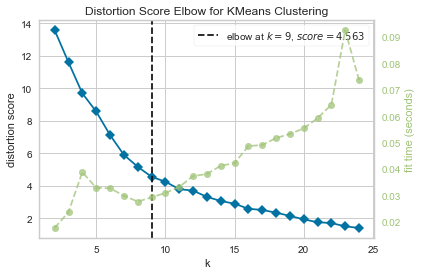

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [169]:
townFeatures = one_hot_encoding_refined.drop(['outCode'], axis=1)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,25))

# Fit the data to the visualizer
visualizer.fit(townFeatures)        
visualizer.show()


Running the Distortion Score Elbow for KMeans Clustering analysis, we see that 9 is the recomended division.

In [170]:
kmeans = KMeans(n_clusters=9, random_state=0).fit(townFeatures)
one_hot_encoding_refined['Cluster'] = kmeans.labels_

In [171]:
boroughClusters = one_hot_encoding_refined[['outCode', 'Cluster']]

In [172]:
londonTowns_df_grouped[['outCode','inCode', 'misc']] = londonTowns_df_grouped['Postcode'].str.split(' ',expand=True)
londonTowns_df_grouped = pd.merge(londonTowns_df_grouped, boroughClusters)

In [173]:
# visualise these loctations on a map
london_clusters = folium.Map(location=[51.4, -0.20], zoom_start=11)

# Add response locations to map
for i, row in londonTowns_df_grouped.iterrows():
    label = folium.Popup(f'{row.Name}')
    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        radius=3,
        popup=label,
        color=colours[int(row.Cluster)],
        parse_html=False).add_to(london_clusters) 

for i, row in borough_df.iterrows():
    if row.Town == 'Teddington':
        col = 'red'
    else:
        col = 'blue'
    label = folium.Popup(f'{row.Town}')

    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        radius=15,
        popup=label,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.3,
        parse_html=False).add_to(london_clusters)

# show map
london_clusters

This analysis has revealed locations with similar characteristics and attractions on a very granular level. Therefore, it is useful to provide a slightly more generalised view of the data and show how specific outcodes have are grouped. 

In [174]:
outCode_culsters = boroughClusters.copy()

for i, row in outCode_culsters.iterrows():
  out = f'https://api.postcodes.io/outcodes/{row.outCode}'
  out = requests.get(out).json()
  try:
    
    outCode_culsters.loc[i, 'latitude'] = out['result']['latitude']
    outCode_culsters.loc[i, 'longitude'] = out['result']['longitude']
  except:
    pass

outCode_culsters = outCode_culsters.dropna()

In [175]:
# visualise these loctations on a map
london_outCodes_clusters = folium.Map(location=[51.4, -0.20], zoom_start=11)

# Add response locations to map
for i, row in outCode_culsters.iterrows():
    label = folium.Popup(f'{row.outCode}')
    folium.CircleMarker(
        [
            row.latitude, 
            row.longitude
        ],
        radius=10,
        popup=label,
        color=colours[int(row.Cluster)],
        fill=True,
        fill_color=colours[int(row.Cluster)],
        fill_opacity=0.3,
        parse_html=False).add_to(london_outCodes_clusters) 

for i, row in borough_df.iterrows():
    if row.Town == 'Teddington':
        col = 'red'
    else:
        col = 'blue'
    label = folium.Popup(f'{row.Town}')

    folium.CircleMarker(
        [
            row.Latitude, 
            row.Longitude
        ],
        radius=15,
        popup=label,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.7,
        parse_html=False).add_to(london_outCodes_clusters)

# show map
london_outCodes_clusters

# Results
As a result of this project, we can now identify areas within Teddington that share similar characteristics and contain similar amenities. With this, we are able to assess our client's current home location and identify regions within the surrounding boroughs that share similar traits. We can thus recommend areas throughout the south of London to which our clients may wish to move. 

Despite spending more time organising and cleaning the categories data in the second iteration, it appears to have had minimal effect on the clustering result. This result suggests that most areas have a range of different restaurants rather than specialising in one single cuisine. This tells me that to begin making more meaningful distinctions between regions. It would be necessary to consider more factors than simply local locations of interest. Such factors could include proximity to commuting lines, quality of schools and side of various outdoor spaces and parks. This analysis has revealed areas with similar characteristics and attractions on a very granular level. Therefore, it may be useful to initially provide a slightly more generalised view of the data and show how specific outcodes have are grouped. 

# Conclusions
I hope that this project has provided an insight into how businesses can use simple data science techniques to impact real-world solutions. From this simple analysis, we are able to suggest to clients areas that are similar to their current location. 

Were this a real-life scenario, I would suggest that we could take this analysis even further. Given the clients initial street address, we could build up a more detailed picture of their area and perform a far more detailed KNN clustering analysis of different London boroughs. Each model could also be tailored to meet client-specific needs; are they interested in close by transport links? Do they want a good selection of pizza restaurants? Ect.
This project is the first step in an analysis process that could go almost infinitely deep. Hopefully, I have been able to demonstrate the power of data science in real-world applications. 
